## 掛接 Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import numpy as np
import tensorflow as tf
import cv2
import tensorflow_datasets as tfds
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from tensorflow.keras.applications.vgg16 import VGG16
from tqdm import tqdm,trange

## 載入資料

In [ ]:
# 確認壓縮檔路徑
filepath='/content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/'
os.listdir(filepath)

['category.xlsx',
 'sample_submission.csv',
 'stanfor_dogs',
 'InceptionResNetV2_model.h5',
 'InceptionResNetV2_loss.png',
 'InceptionResNetV2_acc.png',
 'prediction.csv',
 '「CILSHW3.ipynb」的副本']

In [ ]:
# # 解壓縮檔案
# !unzip '/content/drive/MyDrive/20222電機系電腦視覺/HW3/stanford_dogs.zip' -d '/content/drive/MyDrive/20222電機系電腦視覺/HW3/'

In [ ]:
dirpath='/content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/stanfor_dogs/'
os.listdir(dirpath) 

['test', 'train']

In [ ]:
imgSize=(224,224)
imgShape=(224,224,3)
batchSize=32

# train generator
trainDataGenerator = ImageDataGenerator(rescale = 1/255,
                      # augmentation
                      rotation_range = 40,
                      shear_range = 0.3,
                      zoom_range = 0.2,
                      validation_split=0.3)
valDataGenerator = ImageDataGenerator(rescale=1/255,validation_split=0.3)

trainBatch = trainDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='training'
)

valBatch = valDataGenerator.flow_from_directory(
    directory = dirpath+'train',
    target_size = imgSize,
    class_mode = 'categorical',
    shuffle = True,
    batch_size = batchSize,
    subset='validation'
)

# test generator
testDataGenerator = ImageDataGenerator(rescale=1/255)

testBatch = testDataGenerator.flow_from_directory(
    dirpath,
    class_mode=None,
    shuffle = False,
    batch_size=batchSize,
    target_size= imgSize,
    classes=['test']
)


Found 8400 images belonging to 120 classes.
Found 3600 images belonging to 120 classes.
Found 8580 images belonging to 1 classes.


## 載入模型

In [ ]:
base_model = tf.keras.applications.InceptionResNetV2(
    # include_top = False,
    # weights = 'imagenet',
    # input_tensor = None,
    # input_shape=imgShape,

    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=imgShape,
    pooling=None,
    classes=1000,
    classifier_activation="softmax"
)

x = base_model.output
x = layers.Dropout(0.5)(x)
x = layers.GlobalAveragePooling2D()(x)
#
x = layers.Dropout(0.5)(x)
x = layers.Dense(units = 120, activation = 'relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
#
output_layer = layers.Dense(units = 120, activation = 'softmax')(x)

# freeze the weight
base_model.trainable = False

model = tf.keras.Model(inputs = base_model.input, outputs = output_layer)

219055592/219055592 [==============================] - 12s 0us/step


In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
# show the model stucture (截圖用)
model1 = tf.keras.Sequential([
    base_model,
    layers.Dropout(0.5),
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(units = 120, activation = 'relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    tf.keras.layers.Dense(120, activation="softmax")
])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_resnet_v2 (Functi  (None, 5, 5, 1536)       54336736  
 onal)                                                           
                                                                 
 dropout_3 (Dropout)         (None, 5, 5, 1536)        0         
                                                                 
 global_average_pooling2d_1   (None, 1536)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_4 (Dropout)         (None, 1536)              0         
                                                                 
 dense_2 (Dense)             (None, 120)               184440    
                                                                 
 batch_normalization_204 (Ba  (None, 120)              4

## train model

In [ ]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
from keras.callbacks import ModelCheckpoint
# save the best weights
checkpointer = ModelCheckpoint(filepath="/content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/InceptionResNetV2_model.h5", verbose=1, save_best_only=True)

In [ ]:
epoch=20
history = model.fit(
  trainBatch,
  steps_per_epoch = trainBatch.samples // batchSize,
  validation_data = valBatch,
  validation_steps = valBatch.samples // batchSize,
  epochs=epoch,
  callbacks=[checkpointer]
)

Epoch 1/20
262/262 [==============================] - ETA: 0s - loss: 1.6507 - accuracy: 0.6157 
Epoch 1: val_loss improved from inf to 0.64264, saving model to /content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/InceptionResNetV2_model.h5
262/262 [==============================] - 7227s 28s/step - loss: 1.6507 - accuracy: 0.6157 - val_loss: 0.6426 - val_accuracy: 0.8362
Epoch 2/20
262/262 [==============================] - ETA: 0s - loss: 1.1089 - accuracy: 0.7190
Epoch 2: val_loss improved from 0.64264 to 0.46397, saving model to /content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/InceptionResNetV2_model.h5
262/262 [==============================] - 150s 573ms/step - loss: 1.1089 - accuracy: 0.7190 - val_loss: 0.4640 - val_accuracy: 0.8624
Epoch 3/20
262/262 [==============================] - ETA: 0s - loss: 0.9994 - accuracy: 0.7394
Epoch 3: val_loss improved from 0.46397 to 0.44660, saving model to /content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/InceptionResNetV2_model.h5
262/262 [===========

## show the loss & accuracy curve

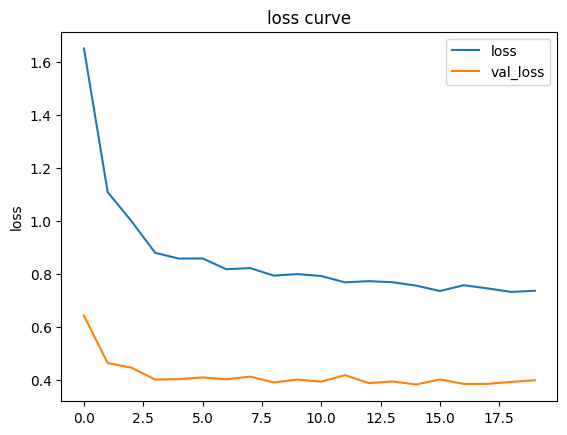

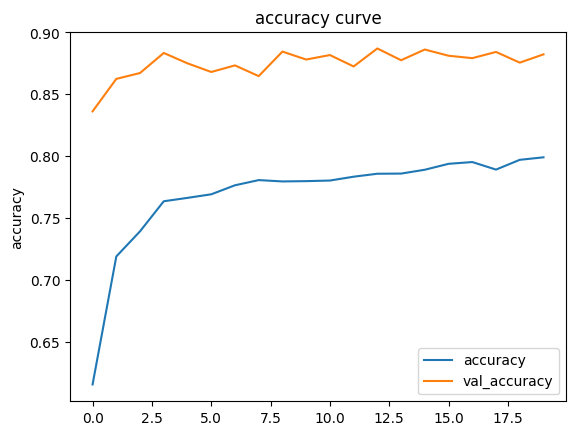

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.title('loss curve')
plt.ylabel('loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/InceptionResNetV2_loss.png')
plt.show()
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.title('accuracy curve')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('/content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/InceptionResNetV2_acc.png')
plt.show()

## predict test data

In [ ]:
prediction = model.predict(testBatch)
prediction

 14/269 [>.............................] - ETA: 1:39:23

## 輸出結果

In [ ]:
prediction_label=prediction.argmax(axis=1)
filename=testBatch.filenames
filename_new=[]
for f in filename:
  filename_new.append(f[5::])

In [ ]:
outputdf=pd.DataFrame()
outputdf['Name']=filename_new
outputdf['Label']=prediction_label
outputdf.to_csv('/content/drive/MyDrive/電腦視覺深度學習實作與應用/2023eehw3/prediction.csv',index=False)